In [6]:
% matplotlib inline

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.externals import joblib
from data import load_jsonl

In [8]:
train = load_jsonl('train.jsonl')

In [9]:
from collections import Counter
import numpy as np
from scipy.stats.stats import pearsonr
from sklearn.metrics import make_scorer
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_selection import SelectKBest, f_regression

IGNORE = {
    'a23_pdistress',
    'a33_pdistress',
    'a42_pdistress',
    'essay',
    'id',
    'a11_bsag_total',
    'a11_bsag_anxiety',
    'a11_bsag_depression',
}


def dis_r(truth, predictions, key_reliab=0.77, pred_reliab=0.70):
    return pearsonr(truth, predictions)[0] / np.sqrt(key_reliab * pred_reliab)


dis_r_score = make_scorer(dis_r, greater_is_better=True)


def make_xy(data, label_name, include=None, exclude=IGNORE):
    X, y = [], []
    for i in data:
        label = i[label_name]
        if label == '':
            continue
        d = {}
        for k, v in i.items():
            if include and k not in include:
                continue
            elif exclude and any(k.startswith(e) for e in exclude):
                continue
            else:
                d[k] = v
        X.append(d)
        y.append(label)
    return X, y


def todense(X):
    return X.todense()


def experiment(data, 
               label_name, 
               feature_names,
               exclude=IGNORE,
               params=None,
               n_jobs=4):
    print(f'Experiment\t{feature_names}\t{label_name}')
    X, y = make_xy(data, label_name,
                   include=feature_names,
                   exclude=exclude)
    
    params = params or {}
    pipeline = make_pipeline(
            DictVectorizer(sparse=False),
            StandardScaler(),
            SGDRegressor(max_iter=1000, 
                         tol=1e3, 
                         penalty='elasticnet', 
                         alpha=0.1),
    )
    grid = GridSearchCV(
        pipeline,
        param_grid=params,
        scoring={
            'dis_r': dis_r_score,
        },
        refit='dis_r',
        n_jobs=n_jobs,
        verbose=0,
        cv=10,
    )
    clf = grid.fit(X, y)
    results = {}
    m = clf.cv_results_['mean_test_dis_r'][clf.best_index_]
    s = clf.cv_results_['std_test_dis_r'][clf.best_index_]
    results['mean_cv_dis_r'] = m
    results['std_cv_dis_r'] = s

    print(f'Results\n{m:.3f}±{2*s:.3f}\t{clf.best_params_}')

    print('\nRanked coefficients:')
    features = clf.best_estimator_.steps[0][1].get_feature_names()
    weights = clf.best_estimator_.steps[-1][1].coef_
    mask = [True for f in features]
    weighted = []  # The list of your K best features
    for selected, feature_name in zip(mask, features):
        if selected:
            weighted.append((feature_name, weights[len(weighted)]))
    for k, v in sorted(weighted, key=lambda i: i[1], reverse=True):
        if not v:
            continue
        print(f'\t{v:.3f}\t{k}')
    return clf, results

all_results = [
    {
        "label": 'Official',
        "a23_pdistress-mean_cv_dis_r": 0.326, "a23_pdistress-std_cv_dis_r": 0,
        "a33_pdistress-mean_cv_dis_r": 0.227, "a33_pdistress-std_cv_dis_r": 0,
        "a42_pdistress-mean_cv_dis_r": 0.196, "a42_pdistress-std_cv_dis_r": 0,
    }
]

## Ablation analysis

In [13]:
SUPERS = [
    'stat',
    'noise',
    'syn',
    'read',
    'LWIC',
    'EXPERT',
    'ents',
    'cntrl',
]

params = {
    'sgdregressor__alpha': [0.01, 0.1, 1],
    'sgdregressor__l1_ratio': [0.1, 0.15, 0.2],
    'sgdregressor__max_iter': [500, 1000, 2000],
}

for s in SUPERS:
    outs = ['a23_pdistress', 'a33_pdistress', 'a42_pdistress']
    label = f'SGDR-all-not-{s}'
    elastic = {'label': label}
    exclude = IGNORE.union({'emb_', f'{s}_'})
    print(label)
    for out in outs:
        clf, results = experiment(train, out, 
                         None,
                         exclude=exclude,
                         params=params,
                         n_jobs=4)
        elastic.update({f'{out}-{metric}': v for metric, v in results.items()})
        #joblib.dump(clf, f'{label}-{out}.pkl')
    all_results.append(elastic)

SGDR-all-not-stat
Experiment	None	a23_pdistress
Results
0.393±0.053	{'sgdregressor__alpha': 0.1, 'sgdregressor__l1_ratio': 0.2, 'sgdregressor__max_iter': 2000}

Ranked coefficients:
	0.327	cntrl_gender
	0.064	read_sentence-beginnings_conjunction
	0.061	EXPERT_p_wealth
	0.056	EXPERT_p_interpersonal-first
	0.044	noise_p_asttoks
	0.034	noise_p_replacement_tokens
	0.031	EXPERT_zero_sport
	0.027	cntrl_a11_social_class=Partly skilled
	0.024	EXPERT_p_sleep
	0.023	EXPERT_zero_occupation-study
	0.018	LIWC_p_LIWC_Certain
	0.012	EXPERT_zero_timeframe
	0.000	ents_p_LAW
	-0.015	read_sentence-info_wordtypes
	-0.024	cntrl_a11_social_class=Skilled non-manual
	-0.038	EXPERT_p_travel
	-0.043	read_sentence-info_characters_per_word
	-0.047	syn_p_pos-DET
	-0.048	cntrl_a11_social_class=Managerial
	-0.055	cntrl_a11_social_class=Professional
Experiment	None	a33_pdistress
Results
0.262±0.063	{'sgdregressor__alpha': 0.1, 'sgdregressor__l1_ratio': 0.2, 'sgdregressor__max_iter': 1000}

Ranked coefficients:
	0.245

/Users/admin/repos/neura-clpsych18/.env/lib/python3.6/site-packages/scipy/stats/stats.py:3003: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


Results
0.265±0.070	{'sgdregressor__alpha': 0.1, 'sgdregressor__l1_ratio': 0.15, 'sgdregressor__max_iter': 1000}

Ranked coefficients:
	0.199	cntrl_gender
	0.083	ents_p_FAC
	0.079	EXPERT_zero_sport
	0.068	EXPERT_zero_house
	0.067	ents_p_PERSON
	0.049	read_sentence-beginnings_conjunction
	0.048	syn_p_pos-SPACE
	0.041	syn_p_pos-INTJ
	0.038	syn_p_pos-CCONJ
	0.029	cntrl_a11_social_class=Unskilled
	0.012	cntrl_a11_social_class=Skilled manual
	0.009	EXPERT_zero_interpersonal-second
	0.008	EXPERT_p_sleep
	-0.001	read_readability-grades_SMOGIndex
	-0.005	read_sentence-info_wordtypes
	-0.007	ents_p_DATE
	-0.009	ents_p_QUANTITY
	-0.012	stat_n_sentences
	-0.019	read_word-usage_nominalization
	-0.020	read_sentence-info_sentences
	-0.020	read_sentence-info_sentences_per_paragraph
	-0.022	EXPERT_p_travel
	-0.027	cntrl_a11_social_class=Professional
	-0.027	cntrl_a11_social_class=Managerial
	-0.042	LIWC_p_LIWC_Affect
	-0.050	read_sentence-info_characters_per_word
	-0.069	syn_p_pos-DET
	-0.069	cntrl_a1

Results
0.262±0.069	{'sgdregressor__alpha': 0.1, 'sgdregressor__l1_ratio': 0.2, 'sgdregressor__max_iter': 500}

Ranked coefficients:
	0.211	cntrl_gender
	0.069	noise_p_replacement_tokens
	0.060	read_sentence-beginnings_conjunction
	0.049	EXPERT_p_sleep
	0.040	cntrl_a11_social_class=Unskilled
	0.038	syn_p_pos-INTJ
	0.029	syn_p_pos-CCONJ
	0.027	ents_p_PERSON
	0.022	read_sentence-info_words_per_sentence
	0.015	EXPERT_zero_interpersonal-not
	0.013	read_readability-grades_LIX
	0.005	ents_p_FAC
	0.003	read_readability-grades_Kincaid
	0.001	read_readability-grades_ARI
	-0.007	ents_p_QUANTITY
	-0.016	EXPERT_p_interpersonal-not
	-0.022	cntrl_a11_social_class=Managerial
	-0.029	EXPERT_p_travel
	-0.029	cntrl_a11_social_class=Professional
	-0.030	read_word-usage_nominalization
	-0.059	read_sentence-info_characters_per_word
	-0.072	syn_p_pos-DET
Experiment	None	a42_pdistress


/Users/admin/repos/neura-clpsych18/.env/lib/python3.6/site-packages/scipy/stats/stats.py:3003: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


Results
0.228±0.099	{'sgdregressor__alpha': 1, 'sgdregressor__l1_ratio': 0.1, 'sgdregressor__max_iter': 1000}

Ranked coefficients:
	0.099	cntrl_gender
SGDR-all-not-EXPERT
Experiment	None	a23_pdistress
Results
0.395±0.079	{'sgdregressor__alpha': 0.1, 'sgdregressor__l1_ratio': 0.15, 'sgdregressor__max_iter': 1000}

Ranked coefficients:
	0.363	cntrl_gender
	0.061	read_sentence-beginnings_conjunction
	0.035	stat_mean_sentence
	0.027	syn_p_pos-PRON
	0.023	cntrl_a11_social_class=Partly skilled
	0.023	cntrl_a11_social_class=Skilled manual
	0.018	LIWC_p_LIWC_Certain
	0.016	noise_p_replacement_tokens
	0.010	cntrl_a11_social_class=Unskilled
	0.001	syn_p_pos-CCONJ
	-0.001	read_sentence-info_complex_words
	-0.011	read_word-usage_nominalization
	-0.020	stat_n_types
	-0.025	read_sentence-info_wordtypes
	-0.034	syn_p_pos-DET
	-0.038	cntrl_a11_social_class=Skilled non-manual
	-0.062	cntrl_a11_social_class=Professional
	-0.069	read_sentence-info_characters_per_word
	-0.073	cntrl_a11_social_class=Manag

/Users/admin/repos/neura-clpsych18/.env/lib/python3.6/site-packages/scipy/stats/stats.py:3003: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


Results
0.271±0.084	{'sgdregressor__alpha': 0.1, 'sgdregressor__l1_ratio': 0.2, 'sgdregressor__max_iter': 2000}

Ranked coefficients:
	0.218	cntrl_gender
	0.039	read_sentence-info_words_per_sentence
	0.038	read_sentence-beginnings_conjunction
	0.037	read_readability-grades_LIX
	0.026	ents_p_FAC
	0.025	syn_p_pos-SPACE
	0.024	read_readability-grades_Kincaid
	0.021	read_readability-grades_GunningFogIndex
	0.021	read_readability-grades_ARI
	0.020	syn_p_pos-INTJ
	0.017	cntrl_a11_social_class=Unskilled
	0.005	syn_p_pos-CCONJ
	0.004	ents_p_PERSON
	-0.001	read_sentence-info_type_token_ratio
	-0.004	ents_p_QUANTITY
	-0.010	read_sentence-info_characters_per_word
	-0.017	LIWC_p_LIWC_Affect
	-0.031	syn_p_pos-DET
	-0.034	cntrl_a11_social_class=Managerial
	-0.041	cntrl_a11_social_class=Professional
	-0.041	cntrl_a11_social_class=Skilled non-manual
Experiment	None	a42_pdistress
Results
0.228±0.099	{'sgdregressor__alpha': 1, 'sgdregressor__l1_ratio': 0.15, 'sgdregressor__max_iter': 1000}

Ranked coeff

/Users/admin/repos/neura-clpsych18/.env/lib/python3.6/site-packages/scipy/stats/stats.py:3003: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/Users/admin/repos/neura-clpsych18/.env/lib/python3.6/site-packages/scipy/stats/stats.py:3003: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/Users/admin/repos/neura-clpsych18/.env/lib/python3.6/site-packages/scipy/stats/stats.py:3003: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/Users/admin/repos/neura-clpsych18/.env/lib/python3.6/site-packages/scipy/stats/stats.py:3003: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/Users/admin/repos/neura-clpsych18/.env/lib/python3.6/site-packages/scipy/stats/stats.py:3003: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/Users/admin/repos/neura-clpsych18/.env/lib/python3.6/site-packages/scipy/stats/stats.py:3003: RuntimeWarning: invalid value 

Results
0.246±0.091	{'sgdregressor__alpha': 0.1, 'sgdregressor__l1_ratio': 0.2, 'sgdregressor__max_iter': 2000}

Ranked coefficients:
	0.071	EXPERT_p_interpersonal-first
	0.067	EXPERT_zero_sport
	0.051	EXPERT_p_hobbies
	0.048	EXPERT_zero_occupation-study
	0.040	stat_mean_sentence
	0.040	LIWC_p_LIWC_Certain
	0.037	syn_p_pos-CCONJ
	0.030	EXPERT_zero_interpersonal-not
	0.027	EXPERT_zero_possessions
	0.021	EXPERT_p_timeframe
	0.016	syn_p_pos-PRON
	0.016	syn_p_pos-INTJ
	0.015	read_sentence-beginnings_conjunction
	0.008	EXPERT_p_affect-positive
	0.003	EXPERT_p_interpersonal-second
	-0.007	syn_p_pos-NUM
	-0.013	stat_p_type
	-0.024	EXPERT_zero_interpersonal-first
	-0.026	read_sentence-info_characters_per_word
	-0.030	read_word-usage_nominalization
	-0.039	EXPERT_zero_physical
	-0.044	read_sentence-info_type_token_ratio
	-0.045	syn_p_pos-DET
	-0.061	EXPERT_zero_interpersonal-second
	-0.065	EXPERT_p_possessions
	-0.074	EXPERT_p_travel
Experiment	None	a33_pdistress


/Users/admin/repos/neura-clpsych18/.env/lib/python3.6/site-packages/scipy/stats/stats.py:3003: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/Users/admin/repos/neura-clpsych18/.env/lib/python3.6/site-packages/scipy/stats/stats.py:3003: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/Users/admin/repos/neura-clpsych18/.env/lib/python3.6/site-packages/scipy/stats/stats.py:3003: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/Users/admin/repos/neura-clpsych18/.env/lib/python3.6/site-packages/scipy/stats/stats.py:3003: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/Users/admin/repos/neura-clpsych18/.env/lib/python3.6/site-packages/scipy/stats/stats.py:3003: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/Users/admin/repos/neura-clpsych18/.env/lib/python3.6/site-packages/scipy/stats/stats.py:3003: RuntimeWarning: invalid value 

Results
0.195±0.065	{'sgdregressor__alpha': 0.1, 'sgdregressor__l1_ratio': 0.2, 'sgdregressor__max_iter': 1000}

Ranked coefficients:
	0.095	ents_p_PERSON
	0.058	read_readability-grades_LIX
	0.058	EXPERT_zero_sport
	0.055	read_sentence-info_words_per_sentence
	0.051	EXPERT_p_interpersonal-first
	0.049	noise_p_replacement_tokens
	0.047	read_readability-grades_Kincaid
	0.043	EXPERT_p_sleep
	0.036	read_readability-grades_ARI
	0.032	read_readability-grades_GunningFogIndex
	0.026	read_sentence-beginnings_conjunction
	0.024	syn_p_pos-INTJ
	0.022	syn_p_pos-SPACE
	0.019	EXPERT_zero_occupation-military
	0.019	EXPERT_zero_interpersonal-not
	0.019	stat_mean_sentence
	0.004	ents_p_WORK_OF_ART
	-0.003	ents_p_ORDINAL
	-0.005	EXPERT_p_occupation-military
	-0.008	EXPERT_p_sport
	-0.008	syn_p_pos-ADP
	-0.012	EXPERT_p_uncertainty
	-0.018	read_readability-grades_FleschReadingEase
	-0.019	ents_p_QUANTITY
	-0.020	EXPERT_p_possessions
	-0.023	LIWC_p_LIWC_Article
	-0.028	EXPERT_p_travel
	-0.029	EXPERT_p_inte

/Users/admin/repos/neura-clpsych18/.env/lib/python3.6/site-packages/scipy/stats/stats.py:3003: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/Users/admin/repos/neura-clpsych18/.env/lib/python3.6/site-packages/scipy/stats/stats.py:3003: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/Users/admin/repos/neura-clpsych18/.env/lib/python3.6/site-packages/scipy/stats/stats.py:3003: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/Users/admin/repos/neura-clpsych18/.env/lib/python3.6/site-packages/scipy/stats/stats.py:3003: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/Users/admin/repos/neura-clpsych18/.env/lib/python3.6/site-packages/scipy/stats/stats.py:3003: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/Users/admin/repos/neura-clpsych18/.env/lib/python3.6/site-packages/scipy/stats/stats.py:3003: RuntimeWarning: invalid value 

Results
0.154±0.115	{'sgdregressor__alpha': 0.1, 'sgdregressor__l1_ratio': 0.2, 'sgdregressor__max_iter': 2000}

Ranked coefficients:
	0.444	LIWC_zero_LIWC_Depression
	0.075	LIWC_zero_LIWC_I
	0.074	EXPERT_p_interpersonal-first
	0.067	EXPERT_zero_sport
	0.059	EXPERT_p_sleep
	0.057	EXPERT_zero_occupation-military
	0.033	noise_p_left_bracket
	0.032	syn_p_pos-PRON
	0.030	read_sentence-beginnings_conjunction
	0.018	stat_mean_sentence
	0.007	EXPERT_p_interpersonal-second
	-0.003	LIWC_p_LIWC_we
	-0.004	EXPERT_zero_physical
	-0.015	read_sentence-info_wordtypes
	-0.018	ents_p_QUANTITY
	-0.019	read_word-usage_nominalization
	-0.032	LIWC_p_LIWC_Depression
	-0.033	ents_p_ORDINAL
	-0.034	EXPERT_p_sport
	-0.037	read_sentence-beginnings_article
	-0.041	EXPERT_zero_natural-pet
	-0.042	EXPERT_p_possessions
	-0.046	EXPERT_p_travel
	-2.918	LIWC_zero_LIWC_Affect


In [14]:
df = pd.DataFrame(all_results, columns=['label', 
                                     'a23_pdistress-mean_cv_dis_r',
                                     'a23_pdistress-std_cv_dis_r',
                                     'a33_pdistress-mean_cv_dis_r',
                                     'a33_pdistress-std_cv_dis_r',
                                     'a42_pdistress-mean_cv_dis_r',
                                     'a42_pdistress-std_cv_dis_r',
                                     ])
df['a23_pdistress-95CI_dis_r'] = 2 * df['a23_pdistress-std_cv_dis_r']
df['a33_pdistress-95CI_dis_r'] = 2 * df['a23_pdistress-std_cv_dis_r']
df['a42_pdistress-95CI_dis_r'] = 2 * df['a42_pdistress-std_cv_dis_r']

In [15]:
df

,label,a23_pdistress-mean_cv_dis_r,a23_pdistress-std_cv_dis_r,a33_pdistress-mean_cv_dis_r,a33_pdistress-std_cv_dis_r,a42_pdistress-mean_cv_dis_r,a42_pdistress-std_cv_dis_r,a23_pdistress-95CI_dis_r,a33_pdistress-95CI_dis_r,a42_pdistress-95CI_dis_r
0,Official,0.326000,0.000000,0.227000,0.000000,0.196000,0.000000,0.000000,0.000000,0.000000
1,SGDR-all-not-stat,0.393251,0.026301,0.262287,0.031490,0.229786,0.049236,0.052602,0.052602,0.098471
2,SGDR-all-not-noise,0.394272,0.036677,0.264682,0.035100,0.231250,0.059924,0.073354,0.073354,0.119849
3,SGDR-all-not-syn,0.403908,0.033440,0.269345,0.032265,0.228513,0.057171,0.066881,0.066881,0.114342
4,SGDR-all-not-read,0.398593,0.027504,0.270262,0.030844,0.232355,0.055430,0.055008,0.055008,0.110860
5,SGDR-all-not-LWIC,0.401512,0.035021,0.261900,0.034299,0.228000,0.049283,0.070041,0.070041,0.098567
6,SGDR-all-not-EXPERT,0.394524,0.039733,0.270977,0.042216,0.228000,0.049283,0.079466,0.079466,0.098567
7,SGDR-all-not-ents,0.394519,0.044680,0.275092,0.024759,0.235383,0.050509,0.089360,0.089360,0.101019
8,SGDR-all-not-cntrl,0.245759,0.045313,0.194818,0.032420,0.153632,0.057733,0.090626,0.090626,0.115466


/Users/admin/repos/neura-clpsych18/.env/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


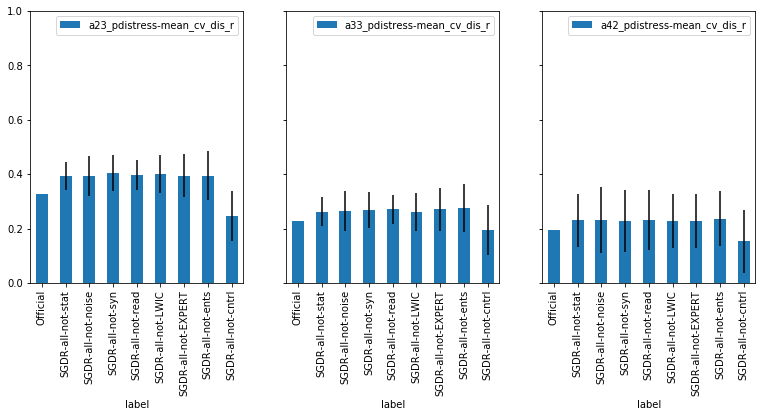

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(13, 5))

df.plot.bar(x='label', y=['a23_pdistress-mean_cv_dis_r'], 
            ax=axes[0], yerr='a23_pdistress-95CI_dis_r',
            ylim=(0, 1))
df.plot.bar(x='label', y=['a33_pdistress-mean_cv_dis_r'], 
            ax=axes[1], yerr='a33_pdistress-95CI_dis_r',
            ylim=(0, 1))
df.plot.bar(x='label', y=['a42_pdistress-mean_cv_dis_r'], 
            ax=axes[2], yerr='a42_pdistress-95CI_dis_r',
            ylim=(0, 1))

In [17]:
raw = load_jsonl('train.raw.jsonl')

In [19]:
outs = ['a23_pdistress', 'a33_pdistress', 'a42_pdistress']
label = f'SGDR-all-raw-{s}'
exclude = IGNORE.union({'emb_'})
print(label)
for out in outs:
    clf, results = experiment(raw, out, 
                     None,
                     exclude=exclude,
                     params=params,
                     n_jobs=4)

SGDR-all-raw-cntrl
Experiment	None	a23_pdistress
Results
0.393±0.058	{'sgdregressor__alpha': 0.1, 'sgdregressor__l1_ratio': 0.2, 'sgdregressor__max_iter': 500}

Ranked coefficients:
	0.372	cntrl_gender
	0.056	read_sentence-beginnings_conjunction
	0.030	stat_mean_sentence
	0.028	ents_p_FAC
	0.028	EXPERT_zero_sport
	0.012	EXPERT_p_interpersonal-second
	0.011	EXPERT_zero_occupation-study
	0.009	EXPERT_p_wealth
	0.006	ents_p_LAW
	0.005	ents_p_LANGUAGE
	0.005	noise_p_asttoks
	-0.013	read_sentence-info_characters_per_word
	-0.021	cntrl_a11_social_class=Professional
	-0.030	EXPERT_p_travel
Experiment	None	a33_pdistress


/Users/admin/repos/neura-clpsych18/.env/lib/python3.6/site-packages/scipy/stats/stats.py:3003: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


Results
0.264±0.090	{'sgdregressor__alpha': 0.1, 'sgdregressor__l1_ratio': 0.15, 'sgdregressor__max_iter': 2000}

Ranked coefficients:
	0.237	cntrl_gender
	0.092	read_sentence-beginnings_conjunction
	0.057	syn_p_pos-SPACE
	0.055	EXPERT_p_sleep
	0.036	cntrl_a11_social_class=Unskilled
	0.028	EXPERT_zero_house
	0.028	read_sentence-info_words_per_sentence
	0.026	EXPERT_zero_interpersonal-not
	0.024	read_readability-grades_LIX
	0.020	EXPERT_zero_sport
	0.015	read_readability-grades_GunningFogIndex
	0.013	read_readability-grades_ARI
	0.012	read_readability-grades_Kincaid
	0.011	LIWC_zero_LIWC_tentative
	0.002	syn_p_pos-INTJ
	-0.005	syn_p_pos-ADV
	-0.008	LIWC_p_LIWC_Affect
	-0.008	read_sentence-beginnings_preposition
	-0.009	EXPERT_zero_sleep
	-0.011	EXPERT_p_interpersonal-not
	-0.016	read_word-usage_nominalization
	-0.017	EXPERT_p_travel
	-0.018	ents_p_DATE
	-0.021	ents_p_QUANTITY
	-0.021	cntrl_a11_social_class=Skilled non-manual
	-0.022	EXPERT_p_sport
	-0.036	syn_p_pos-ADP
	-0.049	cntrl_a11